<h1>Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines</h1>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pf
%matplotlib inline

## Load data

In [2]:
train = pd.read_csv('./training_set_features.csv', index_col='respondent_id')

In [3]:
test = pd.read_csv('./test_set_features.csv', index_col='respondent_id')

In [4]:
labels = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')

### Imputation strategy

In [5]:
num_cols = train.select_dtypes('number').columns

In [6]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [7]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [8]:
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier

In [10]:
# Impute train
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [11]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='missing')

In [12]:
# Impute test
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [13]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='missing')

### Train test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

## Step Forward Selection


In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [16]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [48]:
cat_cols = X_train.select_dtypes('object').columns

In [52]:
ct = ColumnTransformer(
    [('ordinal', oe(), cat_cols)],
    remainder='passthrough')

In [76]:
all_cols = X_train.columns

### Feature selection using CatBoost for H1N1

In [81]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [82]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   33.2s finished

[2020-05-07 00:27:00] Features: 1/35 -- score: 0.7071737862072726[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   39.8s finished

[2020-05-07 00:27:40] Features: 2/35 -- score: 0.7867904926588798[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   48.3s finished

[2020-05-07 00:28:29] Features: 3/35 -- score: 0.8252999311456378[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.5s finished

[2020-05-07 00:47:22] Features: 28/35 -- score: 0.8599795812938107[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.9s finished

[2020-05-07 00:47:54] Features: 29/35 -- score: 0.8586202247986326[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.7s finished

[2020-05-07 00:48:26] Features: 30/35 -- score: 0.8590431492837226[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished

[2020-05-07 00:48:49] Features: 31/

In [83]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(28,)",0.00507775,0.00395066,0.00197533
2,"(21, 28)","[0.7925673159437187, 0.7833433373349339, 0.783...",0.78679,"(21, 28)",0.00803763,0.00625355,0.00312678
3,"(21, 26, 28)","[0.8313290025471703, 0.8251687909206235, 0.814...",0.8253,"(21, 26, 28)",0.00901327,0.00701263,0.00350632
4,"(21, 26, 27, 28)","[0.8470417372912049, 0.8452202157458728, 0.837...",0.844101,"(21, 26, 27, 28)",0.00789697,0.00614411,0.00307206
5,"(10, 21, 26, 27, 28)","[0.8578816984658177, 0.8524703498420645, 0.847...",0.853501,"(10, 21, 26, 27, 28)",0.00832519,0.00647728,0.00323864
6,"(10, 21, 25, 26, 27, 28)","[0.8578906463711131, 0.8515299736916044, 0.849...",0.855233,"(10, 21, 25, 26, 27, 28)",0.00783354,0.00609476,0.00304738
7,"(10, 13, 21, 25, 26, 27, 28)","[0.8595715742944576, 0.8541761385405227, 0.852...",0.857193,"(10, 13, 21, 25, 26, 27, 28)",0.00730726,0.0056853,0.00284265
8,"(5, 10, 13, 21, 25, 26, 27, 28)","[0.8621617798321032, 0.856263994959686, 0.8521...",0.857877,"(5, 10, 13, 21, 25, 26, 27, 28)",0.00836999,0.00651214,0.00325607
9,"(5, 10, 13, 14, 21, 25, 26, 27, 28)","[0.862399538458523, 0.8545422424288865, 0.8544...",0.858748,"(5, 10, 13, 14, 21, 25, 26, 27, 28)",0.00775045,0.00603011,0.00301506
10,"(5, 10, 13, 14, 21, 25, 26, 27, 28, 31)","[0.8626147142763403, 0.8557022809123649, 0.854...",0.860021,"(5, 10, 13, 14, 21, 25, 26, 27, 28, 31)",0.00684154,0.00532295,0.00266148


In [98]:
print(sfdf2.loc[19, 'feature_idx'])

(0, 3, 5, 6, 10, 12, 13, 14, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32)


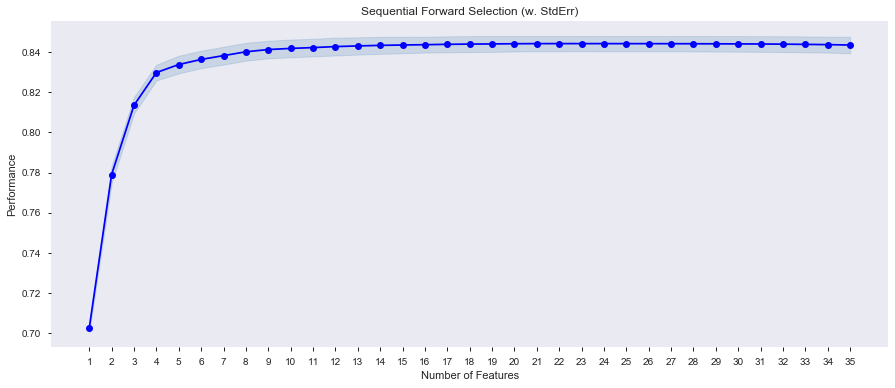

In [85]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [99]:
selected_columns2 = [all_cols[i] for i in 
                     list((0, 3, 5, 6, 10, 12, 13, 14, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32))]

In [100]:
selected_columns2

['h1n1_concern',
 'behavioral_avoidance',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

### Feature selection using CatBoost for seasonal flu

In [89]:
sfs3 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [90]:
sfs3 = sfs3.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   41.4s finished

[2020-05-07 00:53:40] Features: 1/35 -- score: 0.7149885991744259[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   42.4s finished

[2020-05-07 00:54:22] Features: 2/35 -- score: 0.7766078414641167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   43.0s finished

[2020-05-07 00:55:05] Features: 3/35 -- score: 0.811318148880585[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.3s finished

[2020-05-07 01:11:55] Features: 28/35 -- score: 0.8567937973757122[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.5s finished

[2020-05-07 01:12:24] Features: 29/35 -- score: 0.8557434411996896[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.3s finished

[2020-05-07 01:12:49] Features: 30/35 -- score: 0.8569471805350879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.5s finished

[2020-05-07 01:13:11] Features: 31/

In [91]:
sfdf3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
sfdf3

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.704703565267395, 0.7271142898217366, 0.7135...",0.714989,"(31,)",0.00943423,0.00734015,0.00367008
2,"(0, 31)","[0.7679320011500862, 0.7837448246118458, 0.778...",0.776608,"(0, 31)",0.00663211,0.00516001,0.00258
3,"(0, 22, 31)","[0.8103923231742383, 0.8125849626221966, 0.808...",0.811318,"(0, 22, 31)",0.00287633,0.00223788,0.00111894
4,"(0, 22, 30, 31)","[0.8374371765382405, 0.835688757906843, 0.8293...",0.83481,"(0, 22, 30, 31)",0.00369949,0.00287833,0.00143916
5,"(0, 10, 22, 30, 31)","[0.8448720529039677, 0.8480760494537091, 0.838...",0.844628,"(0, 10, 22, 30, 31)",0.00400366,0.00311499,0.00155749
6,"(0, 10, 22, 30, 31, 32)","[0.8511431857389303, 0.8532162162162161, 0.846...",0.850169,"(0, 10, 22, 30, 31, 32)",0.00298461,0.00232213,0.00116106
7,"(0, 10, 13, 22, 30, 31, 32)","[0.8519936745255894, 0.8555786371477861, 0.847...",0.852078,"(0, 10, 13, 22, 30, 31, 32)",0.00344723,0.00268206,0.00134103
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.8537338987924092, 0.8582610695802186, 0.849...",0.854166,"(0, 10, 13, 22, 26, 30, 31, 32)",0.003782,0.00294252,0.00147126
9,"(0, 10, 13, 22, 26, 29, 30, 31, 32)","[0.85508309373203, 0.8589971247843589, 0.84789...",0.854946,"(0, 10, 13, 22, 26, 29, 30, 31, 32)",0.00481745,0.00374814,0.00187407
10,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)","[0.8547544565842438, 0.8601444795859688, 0.848...",0.855745,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)",0.00530315,0.00412603,0.00206301


In [94]:
print(sfdf3.loc[19, 'feature_idx'])

(0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32)


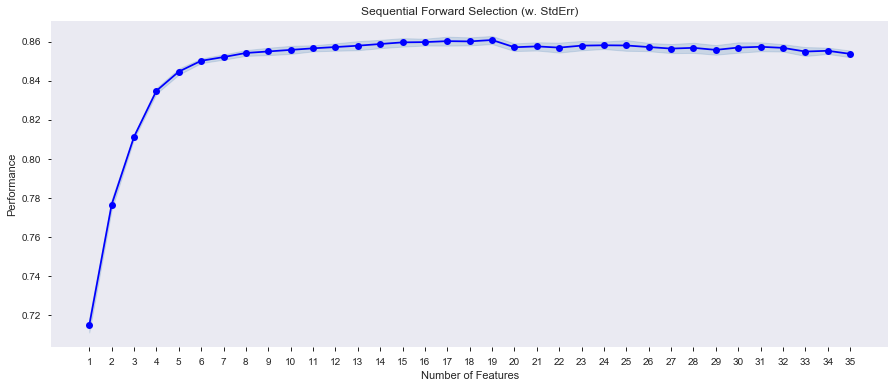

In [93]:
fig = plot_sfs(sfs3.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [96]:
selected_columns3 = [all_cols[i] for i in 
                     list((0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32))]

In [97]:
selected_columns3

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [102]:
selected_columns_h1 = selected_columns2
selected_columns_se = selected_columns3

Essentially there seems to be no advantage to make feature selection for `H1N1` while there might be a small improvment, that must be verified, using only 19 columns for `seasonal flu`

© Andrea Dalseno May 2020